In [1]:
import numpy as np
# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, std=25):
    """
    Add Gaussian noise to an image.

    Args:
        image (PIL.Image): The input image.
        mean (float): Mean of the Gaussian noise.
        std (float): Standard deviation of the Gaussian noise.

    Returns:
        PIL.Image: The image with added noise.
    """
    np_image = np.array(image)
    noise = np.random.normal(mean, std, np_image.shape).astype(np.int16)
    noisy_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

In [2]:
from PIL import Image, ImageDraw
# Function to generate a single image with a geometric shape
def generate_shape_image(shape, size, rotation, img_size=(128, 128), noise=False):
    """
    Generate an image with a single geometric shape.

    Args:
        shape (str): The shape to draw ('circle', 'square', 'triangle').
        size (int): The size of the shape.
        rotation (int): The rotation angle of the shape (degrees).
        img_size (tuple): The size of the image (width, height).
        noise (bool): Whether to add Gaussian noise to the image.

    Returns:
        PIL.Image: The generated image.
    """
    img = Image.new('RGB', img_size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    center = (img_size[0] // 2, img_size[1] // 2)

    if shape == 'circle':
        radius = size // 2
        draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], fill=(0, 0, 0))
    elif shape == 'square':
        half_size = size // 2
        draw.rectangle([center[0] - half_size, center[1] - half_size, center[0] + half_size, center[1] + half_size], fill=(0, 0, 0))
    elif shape == 'triangle':
        half_size = size // 2
        points = [
            (center[0], center[1] - half_size),
            (center[0] - half_size, center[1] + half_size),
            (center[0] + half_size, center[1] + half_size)
        ]
        draw.polygon(points, fill=(0, 0, 0))

    if noise:
        img = add_gaussian_noise(img)

    return img.rotate(rotation)

In [3]:
import random
from pathlib import Path
# Function to generate the dataset and save it to a folder
def generate_dataset(output_dir="dataset", num_images_per_class=1000, img_size=(128, 128), noise=True):
    """
    Generate a dataset of images with geometric shapes and save them to a folder.

    Args:
        output_dir (str): Directory to save the dataset.
        num_images_per_class (int): Number of images per shape class.
        img_size (tuple): Size of the images (width, height).
        noise (bool): Whether to add Gaussian noise to the images.

    Returns:
        list, list: List of image file paths and corresponding labels.
    """
    shapes = ['circle', 'square', 'triangle']
    data = []
    labels = []
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for label, shape in enumerate(shapes):
        shape_dir = output_dir / shape
        shape_dir.mkdir(parents=True, exist_ok=True)

        for i in range(num_images_per_class):
            size = random.randint(20, 80)  # Random size
            rotation = random.randint(0, 360)  # Random rotation
            img = generate_shape_image(shape, size, rotation, img_size, noise)

            # Save image to file
            img_path = shape_dir / f"{shape}_{i}.png"
            img.save(img_path)

            data.append(str(img_path))  # Store file path as string
            labels.append(label)

    return data, labels

In [4]:
# Function to load the dataset from a folder
def load_dataset_from_folder(folder="dataset"):
    """
    Load a dataset of image file paths and labels from a folder.

    Args:
        folder (str): Directory containing the dataset.

    Returns:
        list, list: List of image file paths and corresponding labels.
    """
    folder = Path(folder)
    shapes = ['circle', 'square', 'triangle']
    data = []
    labels = []

    for label, shape in enumerate(shapes):
        shape_dir = folder / shape
        if not shape_dir.exists():
            raise ValueError(f"Shape folder {shape_dir} does not exist. Please generate the dataset first.")

        for img_path in shape_dir.glob("*.png"):
            data.append(str(img_path))  # Store file path as string
            labels.append(label)

    return data, labels

In [5]:
from torch.utils.data import Dataset
# Custom PyTorch Dataset
class ShapeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (list): List of image file paths.
            labels (list): List of labels corresponding to the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Dynamically load the image
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Convert image to tensor
        #image = torch.tensor(np.array(image).transpose(2, 0, 1), dtype=torch.float32) / 255.0
        return image, label

In [6]:
# Function to load the dataset from a folder
def load_dataset_from_folder(folder="dataset"):
    """
    Load a dataset of image file paths and labels from a folder.

    Args:
        folder (str): Directory containing the dataset.

    Returns:
        list, list: List of image file paths and corresponding labels.
    """
    folder = Path(folder)
    shapes = ['circle', 'square', 'triangle']
    data = []
    labels = []

    for label, shape in enumerate(shapes):
        shape_dir = folder / shape
        if not shape_dir.exists():
            raise ValueError(f"Shape folder {shape_dir} does not exist. Please generate the dataset first.")

        for img_path in shape_dir.glob("*.png"):
            data.append(str(img_path))  # Store file path as string
            labels.append(label)

    return data, labels

In [7]:
from torchvision import transforms
from sklearn.model_selection import train_test_split
import shutil
from torch.utils.data import DataLoader
# Main function to prepare the dataset and DataLoader
def prepare_dataloaders(batch_size=32, test_size=0.2, val_size=0.1, num_images_per_class=1000, img_size=(128, 128), noise=False, dataset_dir="dataset"):
    """
    Prepare PyTorch DataLoaders for training, validation, and testing.

    Args:
        batch_size (int): Batch size for the DataLoader. Default is 32.
        test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        val_size (float): Proportion of the dataset to include in the validation split. Default is 0.1.
        num_images_per_class (int): Number of images to generate per shape class. Default is 1000.
        img_size (tuple): Size of the images (width, height). Default is (128, 128).
        noise (bool): Whether to add Gaussian noise to the generated images. Default is False.
        dataset_dir (str): Directory to save/load the dataset. Default is "dataset".

    Returns:
        tuple: A tuple containing three PyTorch DataLoaders:
            - train_loader (DataLoader): DataLoader for the training set.
            - val_loader (DataLoader): DataLoader for the validation set.
            - test_loader (DataLoader): DataLoader for the testing set.
    """
    # Define data augmentation transforms
    train_transform = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(), #Randomly flips the image horizontally with a 50% probability, simulating mirrored versions of the data.
        transforms.RandomVerticalFlip(), # Randomly flips the image vertically with a 50% probability, adding further variability
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #Randomly adjusts the brightness, contrast, saturation, and hue of the image within specified ranges, making the model more robust to lighting and color variations.
        transforms.ToTensor() #Converts the image from a PIL image or NumPy array into a PyTorch tensor and scales pixel values to the range [0, 1].
    ])
    
    val_test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Generate the dataset no matter if it exists or not
    if not Path(dataset_dir).exists():
        print(f"Dataset folder '{dataset_dir}' not found. Generating dataset...")
        generate_dataset(output_dir=dataset_dir, num_images_per_class=num_images_per_class, img_size=img_size, noise=noise)
    else:
        shutil.rmtree(dataset_dir)  # Remove existing dataset folder
        generate_dataset(output_dir=dataset_dir, num_images_per_class=num_images_per_class, img_size=img_size, noise=noise)
    
    data, labels = load_dataset_from_folder(folder=dataset_dir)

    # Split the dataset into train, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size, stratify=labels) # stratify ensures that the split maintains the same proportion of classes
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_size, stratify=train_labels)

    # Create PyTorch Datasets
    train_dataset = ShapeDataset(train_data, train_labels, train_transform)
    val_dataset = ShapeDataset(val_data, val_labels, val_test_transform)
    test_dataset = ShapeDataset(test_data, test_labels, val_test_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [8]:
train_loader, val_loader, test_loader = prepare_dataloaders(dataset_dir="dataset",noise=True)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        #self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  #Input: 3x128x128 Output: 32x64x64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  #Input: 3x128x128 Output: 32x64x64
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  #Input: 32x64x64 Output: 64x32x132
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  #Input: 32x64x64 Output: 64x32x32
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) #Input: 64x32x32 Output: 128x16x16 
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #Input: 64x32x32 Output: 128x16x16
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        #self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) #Input: 128x16x16 Output: 256x8x8 
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #Input: 128x16x16 Output: 256x8x8
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1) #Input: 256x8x8 Output: 512x4x4 

        # Calculate the flattened size after all convolutions and pooling
        self.flattened_size = 512 * 4 * 4  # Output after conv5 and pooling (512x4x4)

        self.fc1 = nn.Linear(self.flattened_size, 1024)  # Fully connected layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 3)  # Output: 3 classes (circle, square, triangle)
        
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Downsample: 32x64x64
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Downsample: 64x32x32
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)  # Downsample: 128x16x16
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)  # Downsample: 256x8x8
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)  # Downsample: 512x4x4

        x = x.view(x.size(0), -1)  # Flatten: 512*4*4
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
train_loader, val_loader, test_loader = prepare_dataloaders(
    batch_size=32, 
    test_size=0.2, 
    val_size=0.1, 
    num_images_per_class=200, 
    img_size=(128, 128), 
    noise=True, 
    dataset_dir="dataset"
)




In [11]:
model = SimpleCNN()
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Training loop


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [13]:
# train the model and save the losses
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50
)


Epoch 1/50, Train Loss: 1.4946, Val Loss: 1.0986
Epoch 2/50, Train Loss: 1.0991, Val Loss: 1.0988
Epoch 3/50, Train Loss: 1.0990, Val Loss: 1.0988
Epoch 4/50, Train Loss: 1.1027, Val Loss: 1.0987
Epoch 5/50, Train Loss: 1.0992, Val Loss: 1.0984
Epoch 6/50, Train Loss: 1.0992, Val Loss: 1.0987
Epoch 7/50, Train Loss: 1.0941, Val Loss: 1.0923
Epoch 8/50, Train Loss: 1.0503, Val Loss: 1.0690
Epoch 9/50, Train Loss: 1.0340, Val Loss: 1.0676
Epoch 10/50, Train Loss: 0.9539, Val Loss: 1.0254
Epoch 11/50, Train Loss: 0.8525, Val Loss: 0.9868
Epoch 12/50, Train Loss: 0.6762, Val Loss: 0.9311
Epoch 13/50, Train Loss: 0.6813, Val Loss: 0.9278
Epoch 14/50, Train Loss: 0.5698, Val Loss: 0.8429
Epoch 15/50, Train Loss: 0.5235, Val Loss: 0.8108
Epoch 16/50, Train Loss: 0.4827, Val Loss: 0.7837
Epoch 17/50, Train Loss: 0.4401, Val Loss: 0.7002
Epoch 18/50, Train Loss: 0.4697, Val Loss: 0.7754
Epoch 19/50, Train Loss: 0.4635, Val Loss: 0.7573
Epoch 20/50, Train Loss: 0.4471, Val Loss: 0.7083
Epoch 21/

In [14]:
import matplotlib.pyplot as plt
# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 2)  # Set y-axis limit to not exceed 2
    plt.title('Training and Validation Loss')
    plt.legend()
    #plt.show()
    plt.savefig('loss_plot.png')

In [15]:
def save_model(model, path='model.pth'):
    """
    Save the trained model to a file.

    Args:
        model (torch.nn.Module): The trained model.
        path (str): Path to save the model.
    """
    torch.save(model.state_dict(), path)

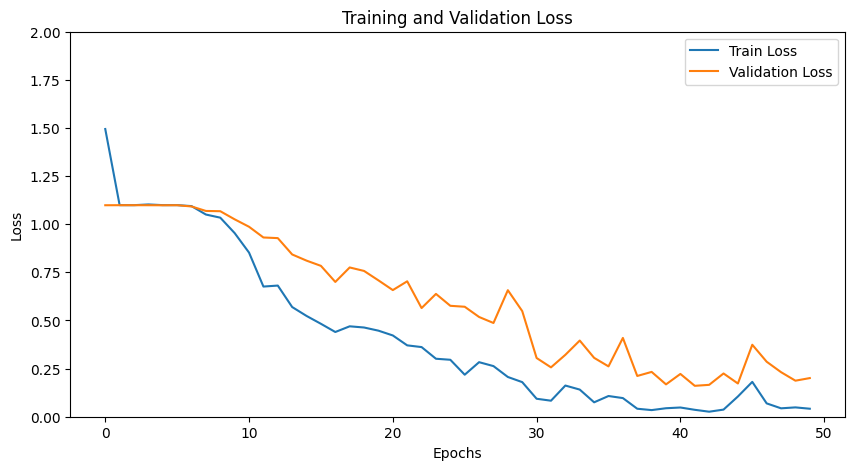

In [16]:
plot_losses(train_losses, val_losses)
save_model(model, path='model.pth')

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    
    sample_images = []
    sample_labels = []
    sample_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        # Collect samples for visualization
        if len(sample_images) < 5:
            sample_images.extend(images.cpu().numpy())
            sample_labels.extend(labels.cpu().numpy())
            sample_preds.extend(preds.cpu().numpy())
            
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    #visualize_samples(sample_images[:5], sample_labels[:5], sample_preds[:5])

    # Confusion matrix
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Circle', 'Square', 'Triangle'], yticklabels=['Circle', 'Square', 'Triangle'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    #plt.show()
    plt.savefig('confusion_matrix.png')

Test Accuracy: 1.0000


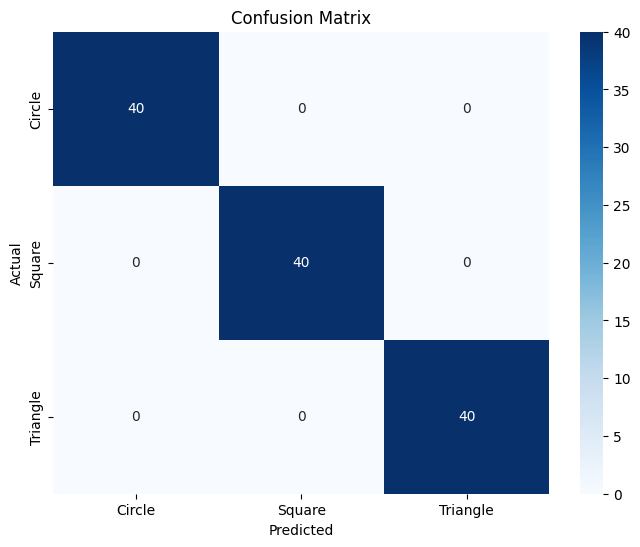

In [18]:
test_model(model,test_loader=test_loader, device=device)

In [19]:
def predict_single_sample(model, image_path, actual_label, device='cpu', class_names=['Circle', 'Square', 'Triangle']):
    """
    Predict a single sample and display the result.

    Args:
        model (nn.Module): The trained model.
        image_path (str): Path to the image file.
        actual_label (int): The actual label of the image.
        device (str): Device to perform the prediction on ('cpu' or 'cuda').
        class_names (list): List of class names.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))  # Resize to match model input size
    image_tensor = torch.tensor(np.array(image).transpose(2, 0, 1), dtype=torch.float32) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    # Display the result
    predicted_label = predicted_label.item()
    print(f"Actual: {class_names[actual_label]}, Predicted: {class_names[predicted_label]}")

    # Visualize the image
    plt.imshow(image)
    plt.title(f"Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label]}")
    plt.axis('off')
    plt.show()

Actual: Circle, Predicted: Circle


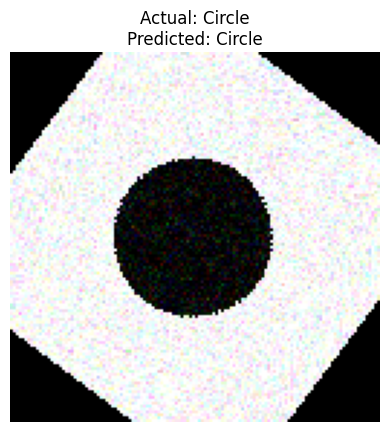

In [20]:
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model.pth', map_location=device))
model.to(device)
model.eval()
# Example usage
sample_image_path = "dataset/circle/circle_0.png"
actual_label = 0  # Actual label of the image (0 for Circle, 1 for Square, 2 for Triangle)
#device = 'cpu'  # Change to 'cuda' if using a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_single_sample(model, sample_image_path, actual_label, device)